# Internet Example of IRIS alone

In [1]:
import tensorflow as tf
import numpy as np

img = np.random.randint(0, 256, (1,64,64,3), np.uint8)

img = (np.float32(img) - 0.0) / 255.0 # normalization (specified in tflite_converter_calculator, not in model card)

model_file = 'iris_landmark.tflite'
interpreter = tf.lite.Interpreter(
    model_path=model_file)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print(f'input_details {input_details}')
print(f'output_details {output_details}')

# check the type of the input tensor
floating_model = input_details[0]['dtype'] == np.float32
print(f'is floating model: {floating_model}')

# NxHxWxC, H:1, W:2
height = input_details[0]['shape'][1]
width = input_details[0]['shape'][2]

interpreter.set_tensor(input_details[0]['index'], img)

interpreter.invoke()

output_eyes = interpreter.get_tensor(output_details[0]['index'])[0]
output_iris = interpreter.get_tensor(output_details[1]['index'])[0]

input_details [{'name': 'input_1', 'index': 0, 'shape': array([ 1, 64, 64,  3]), 'shape_signature': array([ 1, 64, 64,  3]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
output_details [{'name': 'output_eyes_contours_and_brows', 'index': 384, 'shape': array([  1, 213]), 'shape_signature': array([  1, 213]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'output_iris', 'index': 385, 'shape': array([ 1, 15]), 'shape_signature': array([ 1, 15]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_

output iris landmarks x [0.6636077  0.76640826 0.6471603  0.5568398  0.67772526]
output iris landmarks y [0.51719385 0.50089335 0.41648433 0.53332144 0.6193517 ]


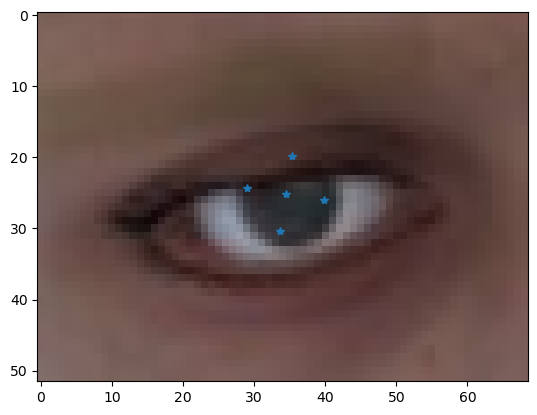

In [12]:
import cv2
import matplotlib.pyplot as plt

image = cv2.imread('000078ZOOMED.jpg')
plt.imshow(image[:,:,::-1])

image_cropped = image[:image.shape[0], :image.shape[0], ::-1] # crop to avoid letterboxing step
plt.imshow(image_cropped)

img = cv2.resize(image_cropped, (64, 64))[np.newaxis, :, :, :]
img = (np.float32(img) - 0.0) / 255.0  # normalization (specified in tflite_converter_calculator, not in model card)

#img = (np.float32(img) - 0.0) / 255.0 # normalization (specified in tflite_converter_calculator, not in model card)
interpreter.set_tensor(input_details[0]['index'], img)

interpreter.invoke()

output_eyes = interpreter.get_tensor(output_details[0]['index'])[0]
output_iris = interpreter.get_tensor(output_details[1]['index'])[0]

print(f'output iris landmarks x {output_iris[::3]/64.0}') # tflite_tensors_to_landmarks_calculator normalization
print(f'output iris landmarks y {output_iris[1::3]/64.0}')

# cropped image
plt.imshow(image_cropped)
plt.plot(output_iris[::3]/64.0*image_cropped.shape[0], (1-output_iris[1::3]/64.0)*image_cropped.shape[1], '*')

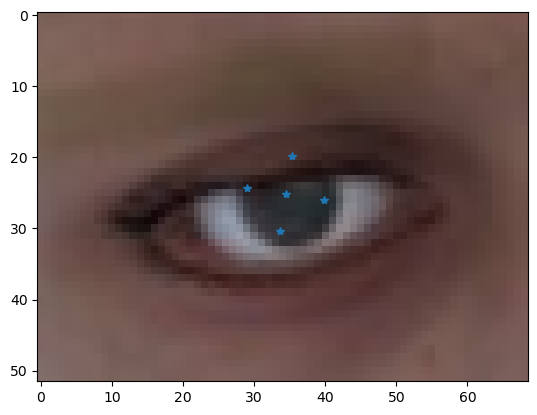

In [13]:
# original image
plt.imshow(image[:,:,::-1])
plt.plot(output_iris[::3]/64.0*image_cropped.shape[0], (1-output_iris[1::3]/64.0)*image_cropped.shape[1], '*')

# Using Library


In [6]:
from fdlite import FaceDetection, FaceDetectionModel
from fdlite.render import Colors, detections_to_render_data, render_to_image 
from PIL import Image

image = Image.open('books/smallme.jpg')
detect_faces = FaceDetection(model_type=FaceDetectionModel.FRONT_CAMERA)
faces = detect_faces(image)
if not len(faces):
    print('no faces detected :(')
else:
    render_data = detections_to_render_data(faces, bounds_color=Colors.GREEN)
    render_to_image(render_data, image).show()

In [9]:
from bisect import bisect_left, bisect_right
from os import PathLike
import numpy as np
from PIL import Image, ImageOps
from PIL.Image import Image as PILImage
import sys
from typing import Sequence, Tuple, Union
from fdlite.face_detection import FaceDetection, FaceDetectionModel
from fdlite.face_landmark import FaceLandmark, face_detection_to_roi
from fdlite.iris_landmark import IrisLandmark, IrisResults
from fdlite.iris_landmark import iris_roi_from_face_landmarks
from fdlite.transform import bbox_from_landmarks
"""Iris recoloring example based on face- and iris detection models.
"""

_Point = Tuple[int, int]
_Size = Tuple[int, int]
_Rect = Tuple[int, int, int, int]


def recolor_iris(
    image: PILImage,
    iris_results: IrisResults,
    iris_color: Tuple[int, int, int]
) -> PILImage:
    """Colorize an eye.
    Args:
        image (Image): PIL image instance containing a face.
        iris_results (IrisResults): Iris detection results.
        iris_color (tuple): Tuple of `(red, green, blue)` representing the
            new iris color to apply. Color values must be integers in the
            range [0, 255].
    Returns:
        (Image) The function returns the modified PIL image instance.
    """
    iris_location, iris_size = _get_iris_location(iris_results, image.size)
    # nothing fancy - just grab the iris part as an Image and work with that
    eye_image = image.transform(iris_size, Image.EXTENT, data=iris_location)
    eye_image = eye_image.convert(mode='L')
    eye_image = ImageOps.colorize(eye_image, 'black', 'white', mid=iris_color)
    # build a mask for copying back into the original image
    # no fancy anti-aliasing or blending, though
    mask = _get_iris_mask(iris_results, iris_location, iris_size, image.size)
    image.paste(eye_image, iris_location, mask)
    return image


def _get_iris_location(
    results: IrisResults, image_size: _Size
) -> Tuple[_Rect, _Size]:
    """Return iris location and -size"""
    bbox = bbox_from_landmarks(results.iris).absolute(image_size)
    width, height = int(bbox.width + 1), int(bbox.height + 1)
    size = (width, height)
    left, top = int(bbox.xmin), int(bbox.ymin)
    location = (left, top, left + width, top + height)
    return location, size


def _get_iris_mask(
    results: IrisResults,
    iris_location: _Rect,
    iris_size: _Size,
    image_size: _Size
) -> PILImage:
    """Return a mask for the visible portion of the iris inside eye landmarks.
    """
    left, top, _, bottom = iris_location
    iris_width, iris_height = iris_size
    img_width, img_height = image_size
    # sort lexicographically by x then y
    eyeball_sorted = sorted([(int(pt.x * img_width), int(pt.y * img_height))
                             for pt in results.eyeball_contour])
    bbox = bbox_from_landmarks(results.eyeball_contour).absolute(image_size)
    x_ofs = left
    y_ofs = top
    y_start = int(max(bbox.ymin, top))
    y_end = int(min(bbox.ymax, bottom))
    mask = np.zeros((iris_height, iris_width), dtype=np.uint8)
    # iris ellipse radii (horizontal and vertical radius)
    a = iris_width // 2
    b = iris_height // 2
    # iris ellipse foci (horizontal and vertical)
    cx = left + a
    cy = top + b
    box_center_y = int(bbox.ymin + bbox.ymax) // 2
    b_sqr = b**2
    for y in range(y_start, y_end):
        # evaluate iris ellipse at y
        x = int(a * np.math.sqrt(b_sqr - (y-cy)**2) / b)
        x0, x1 = cx - x, cx + x
        A, B = _find_contour_segment(eyeball_sorted, (x0, y))
        left_inside = _is_below_segment(A, B, (x0, y), box_center_y)
        C, D = _find_contour_segment(eyeball_sorted, (x1, y))
        right_inside = _is_below_segment(C, D, (x1, y), box_center_y)
        if not (left_inside or right_inside):
            continue
        elif not left_inside:
            x0 = int(max((B[0] - A[0])/(B[1] - A[1]) * (y - A[1]) + A[0], x0))
        elif not right_inside:
            x1 = int(min((D[0] - C[0])/(D[1] - C[1]) * (y - C[1]) + C[0], x1))
        # mark ellipse row as visible
        mask[(y - y_ofs), int(x0 - x_ofs):int(x1 - x_ofs)] = 255
    return Image.fromarray(mask, mode='L')


def _is_below_segment(A: _Point, B: _Point, C: _Point, mid: int) -> bool:
    """Return whether a point is below the line AB"""
    dx = B[0] - A[0]
    dy = B[1] - A[1]
    if not dx:
        # vertical line: check if the point is on the line
        return A[1] <= C[1] and B[1] >= C[1]
    # x -> [0, 1]
    x = (C[0] - A[0]) / dx
    m = dy / dx
    y = x * m + A[1]
    # flip the sign if the leftmost point is below the threshold
    sign = -1 if A[1] > mid else 1
    return sign * (C[1] - y) > 0


def _find_contour_segment(
    contour: Sequence[_Point], point: _Point
) -> Tuple[_Point, _Point]:
    """Find contour segment (points A and B) that contains the point.
    (contour must be lexicographically sorted!)
    """
    def distance(a: _Point, b: _Point) -> int:
        return (a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2

    MAX_IDX = len(contour)-1
    # contour point left of point
    left_idx = max(bisect_left(contour, point) - 1, 0)
    right_idx = min(bisect_right(contour, point), MAX_IDX)
    d = distance(point, contour[left_idx])
    # try to find a closer left point
    while left_idx > 0 and d > distance(point, contour[left_idx - 1]):
        left_idx -= 1
        d = distance(point, contour[left_idx - 1])
    # try to find a closer right point
    d = distance(point, contour[right_idx])
    while right_idx < MAX_IDX and d > distance(point, contour[right_idx + 1]):
        right_idx += 1
        d = distance(point, contour[right_idx + 1])
    return (contour[left_idx], contour[right_idx])


def main(image_file: Union[str, PathLike]) -> None:
    EXCITING_NEW_EYE_COLOR = (161, 52, 216)
    img = Image.open(image_file)
    # run the detection pipeline
    # Step 1: detect the face and get a proper ROI for further processing
    face_detection = FaceDetection(FaceDetectionModel.BACK_CAMERA)
    detections = face_detection(img)
    if not len(detections):
        print('No face detected :(')
        exit(0)
    face_roi = face_detection_to_roi(detections[0], img.size)

    # Step 2: detect face landmarks and extract per-eye ROIs from them
    face_landmarks = FaceLandmark()
    landmarks = face_landmarks(img, face_roi)
    eyes_roi = iris_roi_from_face_landmarks(landmarks, img.size)

    # Step 3: perform iris detection to get detailed landmarksfor each eye
    iris_landmarks = IrisLandmark()
    left_eye_roi, right_eye_roi = eyes_roi
    left_eye_results = iris_landmarks(img, left_eye_roi)
    right_eye_results = iris_landmarks(img, right_eye_roi, is_right_eye=True)

    # Step 4: apply new eye and exciting eye color
    recolor_iris(img, left_eye_results, iris_color=EXCITING_NEW_EYE_COLOR)
    recolor_iris(img, right_eye_results, iris_color=EXCITING_NEW_EYE_COLOR)

    # Step 5: Profit! ...or just show the result ¯\_(ツ)_/¯
    img.show()


if __name__ == '__main__':
    if len(sys.argv) != 2:
        print('pass an image name as argument')
    else:
        main(sys.argv[1])

pass an image name as argument


In [ ]:
EXCITING_NEW_EYE_COLOR = (161, 52, 216)
img = Image.open("books/metest.jpg")
    # run the detection pipeline
    # Step 1: detect the face and get a proper ROI for further processing
face_detection = FaceDetection(FaceDetectionModel.BACK_CAMERA)
detections = face_detection(img)
if not len(detections):
        print('No face detected :(')
        exit(0)
face_roi = face_detection_to_roi(detections[0], img.size)

    # Step 2: detect face landmarks and extract per-eye ROIs from them
face_landmarks = FaceLandmark()
landmarks = face_landmarks(img, face_roi)
eyes_roi = iris_roi_from_face_landmarks(landmarks, img.size)

    # Step 3: perform iris detection to get detailed landmarksfor each eye
iris_landmarks = IrisLandmark()
left_eye_roi, right_eye_roi = eyes_roi
left_eye_results = iris_landmarks(img, left_eye_roi)
right_eye_results = iris_landmarks(img, right_eye_roi, is_right_eye=True)

    # Step 4: apply new eye and exciting eye color
recolor_iris(img, left_eye_results, iris_color=EXCITING_NEW_EYE_COLOR)
recolor_iris(img, right_eye_results, iris_color=EXCITING_NEW_EYE_COLOR)

    # Step 5: Profit! ...or just show the result ¯\_(ツ)_/¯
img.show()
